In [1]:
import os
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yaml
from loguru import logger
from tqdm import tqdm

from data.dataset import Sentinel2TCIDataset, Sentinel2Dataset
from data.loader import define_loaders
from model_zoo.models import define_model
from training.metrics import MultiSpectralMetrics, avg_metric_bands
from utils.torch import count_parameters, load_model_weights, seed_everything
from utils.utils import load_config
from utils.wandb_logger import WandbLogger
from training.losses import WeightedMSELoss

/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/miniconda3/envs/ai_processor/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:


def setup_environment(config, log_path):
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    logger.add(log_path, rotation="10 MB")
    seed_everything(seed=config['TRAINING']['seed'])


def prepare_paths(path_dir):


    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output


def prepare_data(config):
    base_dir = config['DATASET']['base_dir']
    version = config['DATASET']['version']
    resize = config['TRAINING']['resize']


    TRAIN_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/train/"
    VAL_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/val/"
    TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"

    df_train_input, df_train_output =  prepare_paths(TRAIN_DIR)
    df_val_input, df_val_output =  prepare_paths(VAL_DIR)
    df_test_input, df_test_output =  prepare_paths(TEST_DIR)
    
    logger.info(f"Number of training samples: {len(df_train_input)}")
    logger.info(f"Number of validation samples: {len(df_val_input)}")
    logger.info(f"Number of test samples: {len(df_test_input)}")

    train_dataset = Sentinel2Dataset(df_x=df_train_input, df_y=df_train_output, train=True, augmentation=False, img_size=resize)
    val_dataset = Sentinel2Dataset(df_x=df_val_input, df_y=df_val_output, train=True, augmentation=False, img_size=resize)
    test_dataset = Sentinel2Dataset(df_x=df_test_input, df_y=df_test_output, train=True, augmentation=False, img_size=resize)



    train_loader, val_loader = define_loaders(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        train=True,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    test_loader = define_loaders(
        train_dataset=test_dataset,
        val_dataset=None,
        train=False,
        batch_size=config['TRAINING']['batch_size'],
        num_workers=config['TRAINING']['num_workers'])

    return train_loader, val_loader, test_loader


In [3]:
config = load_config(config_path="cfg/config.yaml")
version = "V3"
resize = 1024
TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_input, df_output = prepare_paths(TEST_DIR)
random_index = np.random.choice(df_input.index)
random_row = df_input.loc[random_index]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


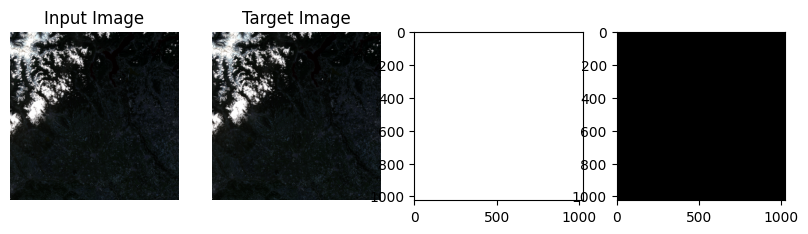

In [78]:
import natsort
import glob
import cv2
from PIL import Image


def normalize(band, lower_percent=2, upper_percent=98):
    """
    Normalize a band using percentile stretching. Returns both the normalized band and a validity mask.
    """
    valid_mask = (band > 0)
    if not np.any(valid_mask):
        return np.zeros_like(band, dtype=np.float32), np.zeros_like(band, dtype=bool)

    valid_pixels = band[valid_mask]
    lower = np.percentile(valid_pixels, lower_percent)
    upper = np.percentile(valid_pixels, upper_percent)
    result = band.copy().astype(np.float32)
    result[valid_mask] = np.clip((band[valid_mask] - lower) / (upper - lower), 0, 1)
    result[~valid_mask] = 0.0
    return result, valid_mask


def read_images(product_paths):
    images = []
    masks = []

    for path in product_paths:
        data = Image.open(path)
        data = np.array(data)
        norm_data, valid_mask = normalize(data)
        images.append(norm_data)
        masks.append(valid_mask)

    images = np.dstack(images)  # H x W x C
    valid_masks = np.dstack(masks)  # H x W x C

    return images, valid_masks

random_index = np.random.choice(df_input.index)
random_row = df_input.loc[random_index]
x_paths = natsort.natsorted(glob.glob(os.path.join(df_input["path"][random_index], "*.png")))
x_data, x_mask = read_images(x_paths)
x_data = cv2.resize(x_data, (resize, resize), interpolation=cv2.INTER_AREA)
x_mask = cv2.resize(x_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST)

y_paths = natsort.natsorted(glob.glob(os.path.join(df_input["path"][random_index], "*.png")))
y_data, y_mask = read_images(y_paths)
y_data = cv2.resize(y_data, (resize, resize), interpolation=cv2.INTER_AREA)
y_mask = cv2.resize(y_mask.astype(np.uint8), (resize, resize), interpolation=cv2.INTER_NEAREST)

valid_mask = x_mask & y_mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(x_data)
plt.title("Input Image")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(y_data)
plt.title("Target Image")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(valid_mask*255)

plt.subplot(1, 4, 4)

plt.imshow((x_mask-y_mask)*255)

plt.show()
# Load the model